In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
import re
import pickle
import os, sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from preprocess.clean_and_tokenize import clean_and_tokenize_one
from scripts.predict_topics import gen_topic_map, predict_complaint_topics

[nltk_data] Downloading package punkt to /Users/sueliu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [200]:
df = pd.read_csv('complaints_full.csv')

In [201]:
df['date'] = pd.to_datetime(df['date_time'])

In [25]:
with open('../nationwide/input/lda_45_topics.pkl', 'rb') as f:
    data = pickle.load(f)
lda_model = data['model']
vectorizer = data['vectorizer']

topic_map = gen_topic_map('../nationwide/input/topics_matching.xlsx')

In [228]:
topic_map_df = pd.DataFrame(topic_map, index=[0]).T.reset_index()
topic_map_df.columns=['topic_id', 'topic_name']

In [229]:
to_postgres(topic_map_df,'prototyping.complaints_topic_names', create_engine(con_str))

prototyping.complaints_topic_names doesn't exist - CREATING


In [28]:
text_field = 'compliant_text_cleaned'
df[text_field]

"I wouldn't recommend opening a Help to Buy ISA here. My partner was with Halifax and got an instant transfer of funds when closing the account including the final statement on the spot... Went to close at Nationwide, and we have to wait 5-7 days for the closing statement and either receive the money via cheque of pay £20 to transfer it electronically. Not sure what other banks are like but the Halifax experience was much better."

In [202]:
 # Clean complaints text prior to prediction
df['cleaned'] = df[text_field].astype(str).apply(clean_and_tokenize_one)

    # Apply Countvectorizer transform and then LDA predict
vectorized = vectorizer.transform(df['cleaned'])
topics = lda_model.transform(vectorized)

In [203]:
topics.shape

(8796, 45)

In [204]:
import numpy as np
top_n = 5

In [286]:
all_output = []
for c in range(topics.shape[0]):
    output = dict()
    # We need to output the original narrative for comparison
    output['idx'] = df['Unnamed: 0'].values[c]
    output['company'] = df['company'].values[c]
    output['review_title'] = df['review_title'].values[c]
    output['date'] = df['date'].values[c]
    output['review_narrative'] = df[text_field].values[c]
    topic_indices = np.argsort(topics[c, :])[::-1]
    topic_prob = np.sort(topics[c, :])[::-1]
    
    topics_data = {}
    for importance_count, [idx, prob] in enumerate(list(zip(topic_indices, topic_prob))[:top_n]):
        topics_data[topic_map[int(idx)]] = prob
    output['topics'] = topics_data
    all_output.append(output)    

In [276]:
all_output = []
for c in range(topics.shape[0]):
    output = dict()
    # We need to output the original narrative for comparison
    output['idx'] = df['Unnamed: 0'].values[c]
    output['company'] = df['company'].values[c]
    output['review_title'] = df['review_title'].values[c]
    output['date'] = df['date'].values[c]
    output['review_narrative'] = df[text_field].values[c]
    
    for i in range(topics.shape[1]):
        output['topic_{}'.format(i)] = topics[c, i]
    all_output.append(output)

In [287]:
output_df = pd.DataFrame.from_records(all_output)

In [295]:
print(output_df.iloc[4]['review_narrative'])
print(output_df.iloc[4]['topics'])

I went for a new 5-year mortgage and was "guaranteed" that I could get an additional mortgage.  You can't...  They ask for riddiculous things such sending statements from 2010!.  Now in the process of moving to another mortgage lender and will be moving ISA, Credit Cards and Current account from this sorry non-caring company.Nationwide seem very keen on marketing their products but when it comes to it they don't want actually want your business.
{'Taking out or refinancing mortgage': 0.35427235747478814, 'Customer support': 0.14466843102230484, 'Communications with company': 0.11173885232929624, 'Credit card account': 0.11137803774883945, 'Signing contracts': 0.10084570467774094}


In [92]:
output_df.company.unique()

array(['www.nationwide.co.uk', 'www.hsbc.co.uk', 'lloydsbank.com',
       'www.natwest.com', 'www.barclays.co.uk', 'tsb.co.uk',
       'www.halifax.co.uk', 'www.rbs.co.uk'], dtype=object)

In [148]:
with open("/Users/sueliu/cred.secret", 'r') as f:
    con_str = f.read().strip()

In [297]:
to_postgres(output_df, 'prototyping.complaints_trustpilot', get_engine(con_str), text_cols=['review_title', 'review_narrative'])

In [186]:
from pandas.api.types import is_string_dtype

In [274]:
def clean_rows(df, text_cols):
    for col in text_cols:
        if is_string_dtype(df[col]):
            df[col] = df[col].str.replace('|', '')
    return df

In [176]:
output_df.iloc[2947, :]['review_narrative']

"I am a HSBC Customer for over 20 years and have to say they seem to be going from best Bank to worst in those 20 years they have  Closed my Local Branch down ( which was open for over 50 years) |I am a Advance banking Customer  that means u pay extra for what it used to be for UK call centres now mainly have Calls answered from Countries other then UK , who  i don't understand when they SpeakI have had tried to Explain my View to the Bank but its on Deaf Ears"

In [104]:
complaint_counts = []
for company, data in output_df.groupby('company'):
    complaint_counts.append(data.set_index('date').resample('M').count()['idx'])

In [108]:
all_counts = pd.concat(complaint_counts, axis=1)
all_counts.columns = ['www.nationwide.co.uk', 'www.hsbc.co.uk', 'lloydsbank.com',
       'www.natwest.com', 'www.barclays.co.uk', 'tsb.co.uk',
       'www.halifax.co.uk', 'www.rbs.co.uk']

In [140]:
from sqlalchemy import event, create_engine

In [142]:
from io import StringIO

In [225]:
def get_engine(con_string):
    engine = create_engine(con_string)
    return engine

In [296]:
def to_postgres(df, table_name, con, text_cols=None):
    data = StringIO()
    if text_cols is not None:
        df = clean_rows(df, text_cols)
    df.to_csv(data, header=False, index=False, sep='|')
    data.seek(0)
    raw = con.raw_connection()
    curs = raw.cursor()
    try:
        curs.execute('DROP TABLE ' + table_name)
    except:
        raw = con.raw_connection()
        curs = raw.cursor()
        print("{} doesn't exist - CREATING".format(table_name))
    #empty_table = 'CREATE TABLE ' + table_name + ' (\n"idx" TEXT,\n  "company" TEXT,\n  "review_title" TEXT,\n  "date" TIMESTAMP,\n  "review_narrative" TEXT,\n  "topics" JSON\n)'
    empty_table = pd.io.sql.get_schema(df, table_name, con=con)
    empty_table = empty_table.replace('"', '')
    curs.execute(empty_table)
    curs.copy_from(data, table_name, sep='|')
    curs.execute("grant select on {} to grp_dev".format(table_name))
    curs.connection.commit()

In [232]:
from sqlalchemy.types import TEXT, JSON, TIMESTAMP

In [235]:
pd.io.sql.get_schema(output_df, 'prototyping.complaints_trustpilot')

'CREATE TABLE "prototyping.complaints_trustpilot" (\n"idx" TEXT,\n  "company" TEXT,\n  "review_title" TEXT,\n  "date" TIMESTAMP,\n  "review_narrative" TEXT,\n  "topics" TEXT\n)'

In [114]:
import matplotlib.pyplot as plt
import seaborn as sns


In [126]:
import plotly.plotly as py
import plotly
import cufflinks as cf
import pandas as pd
import numpy as np
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()

In [165]:
df.to_csv?

In [123]:
import cufflinks as cf

In [130]:
plotly.offline.plot?

In [131]:
fig = all_counts.iplot(kind='scatter', asFigure=True)
plotly.offline.plot(fig,filename="example.html")

'example.html'

In [101]:
nationwide = output_df[output_df.company == 'www.natwest.com']

In [85]:
%matplotlib inline

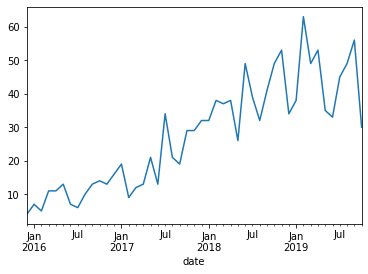

In [103]:
nationwide.set_index('date').resample('M').count()['idx'].plot()